In [29]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('s8163d5w/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   environment.instances.train                654 non-null    object 
 1   actor.net_spec.depth                       654 non-null    int64  
 2   actor.net_spec.num_cells                   654 non-null    int64  
 3   agent.activation                           654 non-null    object 
 4   agent.actor_lr                             654 non-null    float64
 5   agent.actor_weight_decay                   654 non-null    float64
 6   agent.critic_lr                            654 non-null    float64
 7   agent.lag_lr                               654 non-null    float64
 8   agent.lagrange.params.initial_value        654 non-null    int64  
 9   agent.lagrange.positive_violation          654 non-null    bool   
 10  agent.loss_module.entropy_

In [7]:
float_df = df.copy()
float_df['environment.instances.train'] = df['environment.instances.train'].apply(lambda s: int(s.split(' ')[0]))
float_df['agent.activation'] = df['agent.activation'].apply(lambda s: 0 if s == 'TANH' else 1)
float_df['environment.params.cost_fn_type'] = df['environment.params.cost_fn_type'].apply(lambda s: 0 if s == 'SPARSE' else 1)

hps = [c for c in float_df.columns if 'valid' not in c and c != 'cost_limit']
to_drop = [c for c in float_df.columns if 'valid' in c] + ['cost_limit']
metrics = [c for c in float_df.columns if 'valid/best/stoch' in c]
hps2label = {'environment.instances.train': 'train_instances',
 'actor.net_spec.depth': 'actor_depth',
 'actor.net_spec.num_cells': 'actor_width',
 'agent.activation': 'activation',
 'agent.actor_lr': 'actor_lr',
 'agent.actor_weight_decay': 'weight_decay',
 'agent.critic_lr': 'critic_lr',
 'agent.lag_lr': 'lag_lr',
 'agent.lagrange.params.initial_value': 'initial_lag',
 'agent.lagrange.positive_violation': 'positive_violation',
 'agent.loss_module.entropy_bonus': 'entropy_bonus',
 'agent.loss_module_lag.cost_scale': 'cost_scale',
 'agent.loss_module_lag.reward_scale': 'reward_scale',
 'agent.loss_module_lag.target_kl': 'target_kl',
 'agent.orthogonal_init': 'orthogonal_init',
 'agent.schedule': 'schedule',
 'critic.net_spec.depth': 'critic_depth',
 'critic.net_spec.num_cells': 'critic_width',
 'environment.params.cost_fn_type': 'cost_fn_type',
 'training.batch_size': 'batch_size',
 'training.frames_per_batch': 'frames_per_batch',
 'training.num_envs': 'num_envs',
 'training.num_epochs': 'num_epochs'}

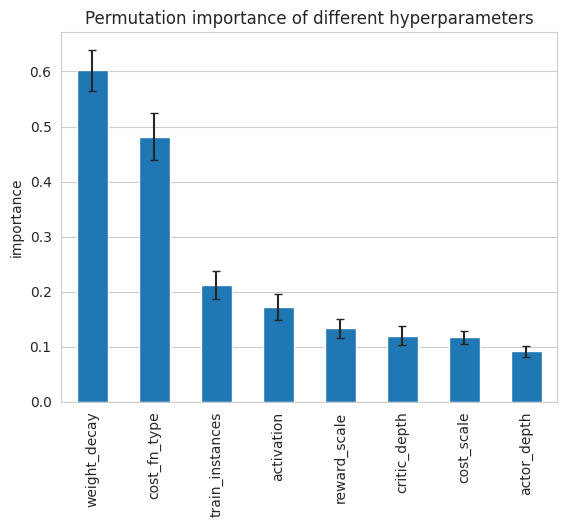

In [8]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance

X = float_df[hps].values
y = float_df['valid/best/stochastic/avg_cost'].values
forest = ExtraTreesRegressor(random_state=42, n_jobs=-1)
forest.fit(X, y)

permutation = permutation_importance(forest, X, y, n_repeats=100, random_state=42, n_jobs=-1)

data = pd.DataFrame({'importance': permutation.importances_mean, 'std': permutation.importances_std}, index=[hps2label[hp] for hp in hps]).sort_values(by='importance', ascending=False)

data[data['importance'] >= 0.09].plot.bar(y='importance', yerr='std', capsize=3)
plt.title('Permutation importance of different hyperparameters')
plt.ylabel('importance')
plt.legend().remove()
plt.grid(axis='x')

<Axes: >

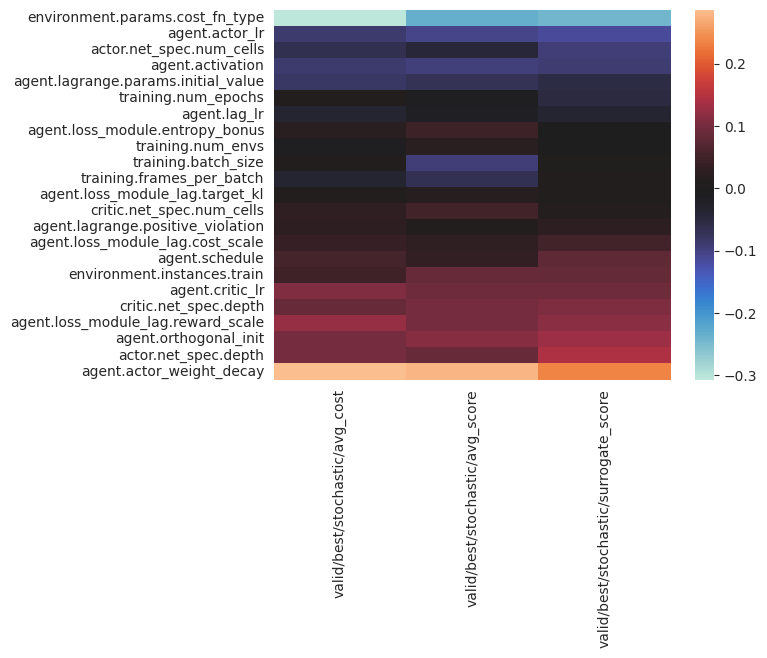

In [9]:
hm = float_df.corr(method='spearman').drop(index=to_drop)[metrics].sort_values(by='valid/best/stochastic/surrogate_score')
sns.heatmap(hm, center=0.0)

In [10]:
def compute_ci(x):
    from scipy.stats import bootstrap
    """Compute bootstrap confidence interval for a given array of values."""
    ci = bootstrap([x], statistic=np.mean, random_state=42).confidence_interval
    return ci.low, ci.high

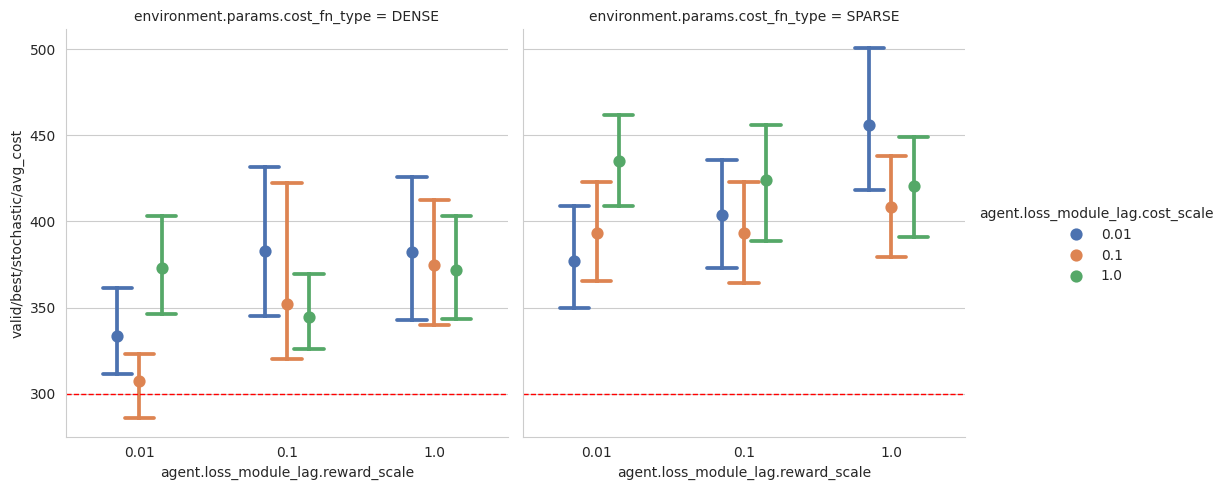

In [11]:
cplot = sns.catplot(df, x='agent.loss_module_lag.reward_scale', y=f'valid/best/stochastic/avg_cost', kind='point', col='environment.params.cost_fn_type', hue='agent.loss_module_lag.cost_scale', palette=sns.color_palette('deep', 3),
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.3)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

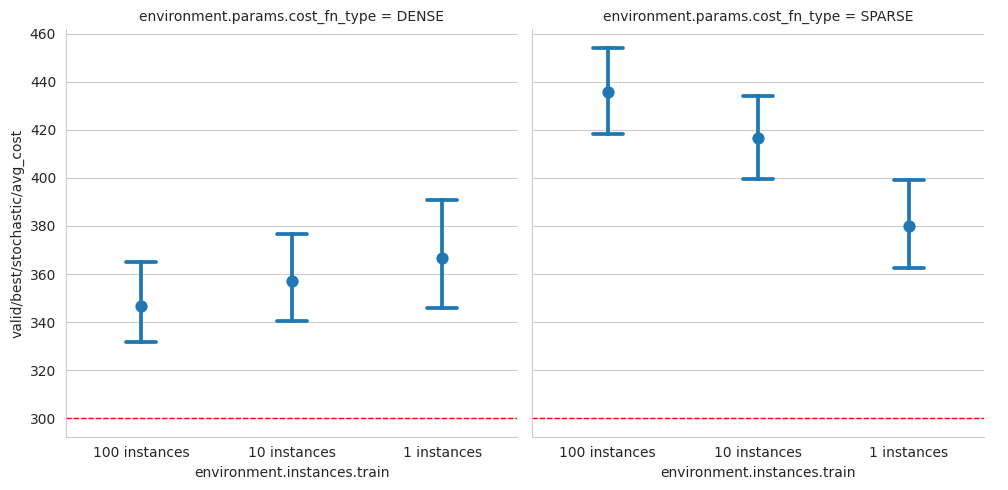

In [12]:
cplot = sns.catplot(df, x='environment.instances.train', y=f'valid/best/stochastic/avg_cost', kind='point', col='environment.params.cost_fn_type', 
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=None)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

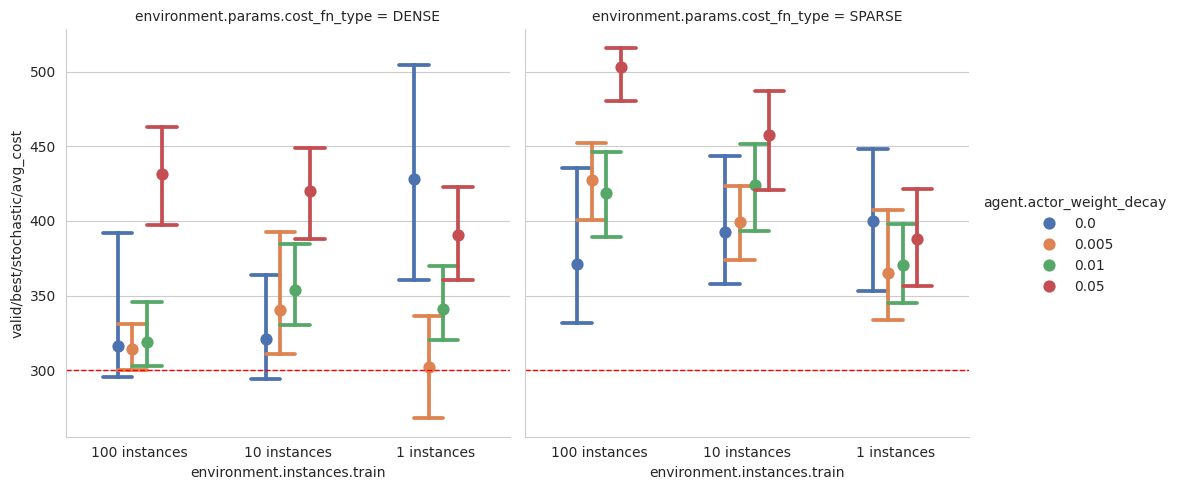

In [13]:
cplot = sns.catplot(df, x='environment.instances.train', y=f'valid/best/stochastic/avg_cost', kind='point', col='environment.params.cost_fn_type', hue='agent.actor_weight_decay', palette=sns.color_palette('deep', 4),
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.3)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

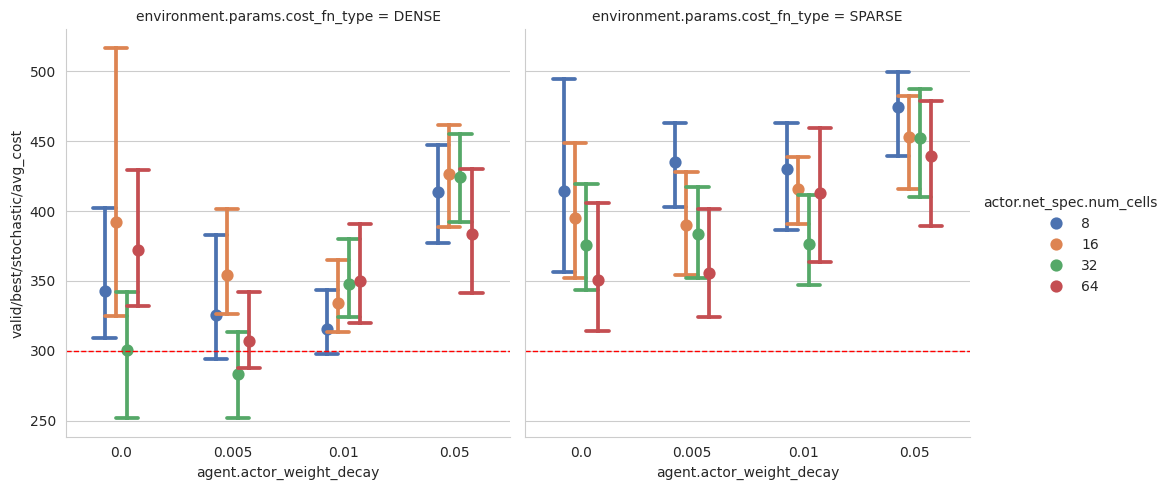

In [14]:
cplot = sns.catplot(df, x='agent.actor_weight_decay', y=f'valid/best/stochastic/avg_cost', kind='point', palette=sns.color_palette('deep', 4),
            hue='actor.net_spec.num_cells', col='environment.params.cost_fn_type',
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.3)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

In [15]:
filtered_df = df[df['environment.params.cost_fn_type'] == 'DENSE']
filtered_df = filtered_df[filtered_df['environment.instances.train'] == '100 instances']

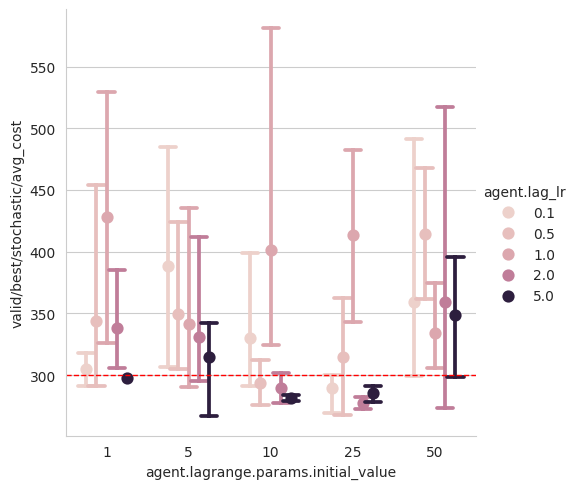

In [16]:
cplot = sns.catplot(filtered_df, x='agent.lagrange.params.initial_value', y=f'valid/best/stochastic/avg_cost', kind='point', 
            hue='agent.lag_lr', errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.5)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

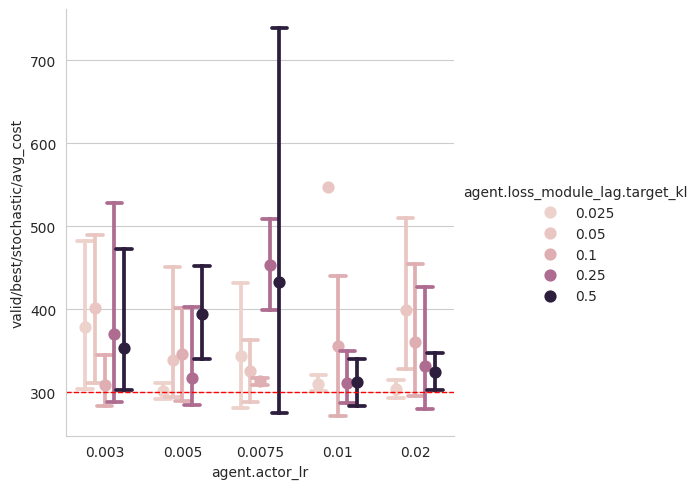

In [17]:
cplot = sns.catplot(filtered_df, x='agent.actor_lr', y=f'valid/best/stochastic/avg_cost', kind='point', 
            hue='agent.loss_module_lag.target_kl', errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.5)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

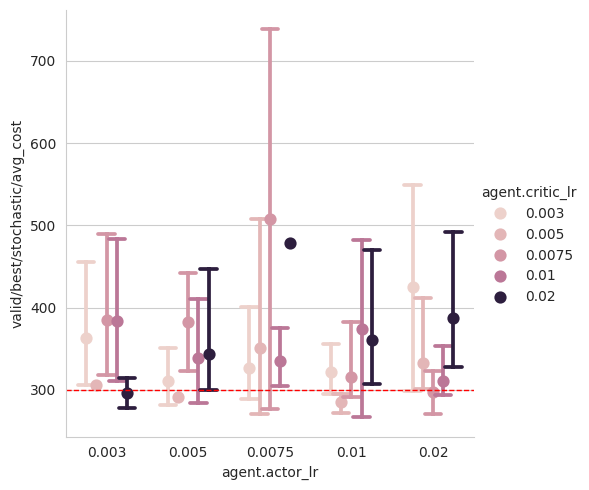

In [18]:
cplot = sns.catplot(filtered_df, x='agent.actor_lr', y=f'valid/best/stochastic/avg_cost', kind='point', 
                hue='agent.critic_lr', errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.5)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

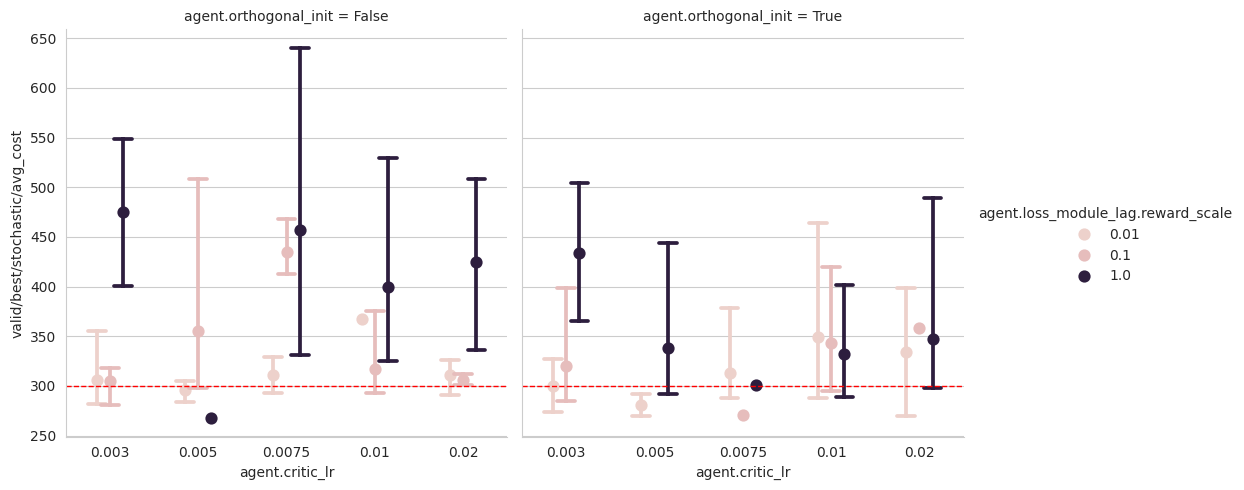

In [19]:
cplot = sns.catplot(filtered_df, x='agent.critic_lr', y=f'valid/best/stochastic/avg_cost', kind='point', 
            hue='agent.loss_module_lag.reward_scale', col='agent.orthogonal_init',
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.3)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

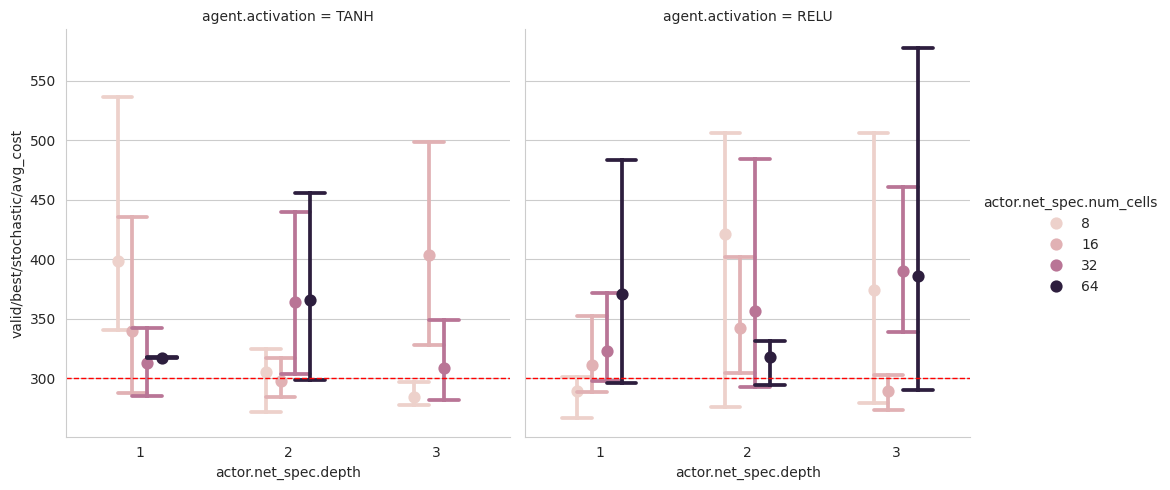

In [20]:
cplot = sns.catplot(filtered_df, x='actor.net_spec.depth', y=f'valid/best/stochastic/avg_cost', kind='point', 
            hue='actor.net_spec.num_cells', col='agent.activation',
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.3)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

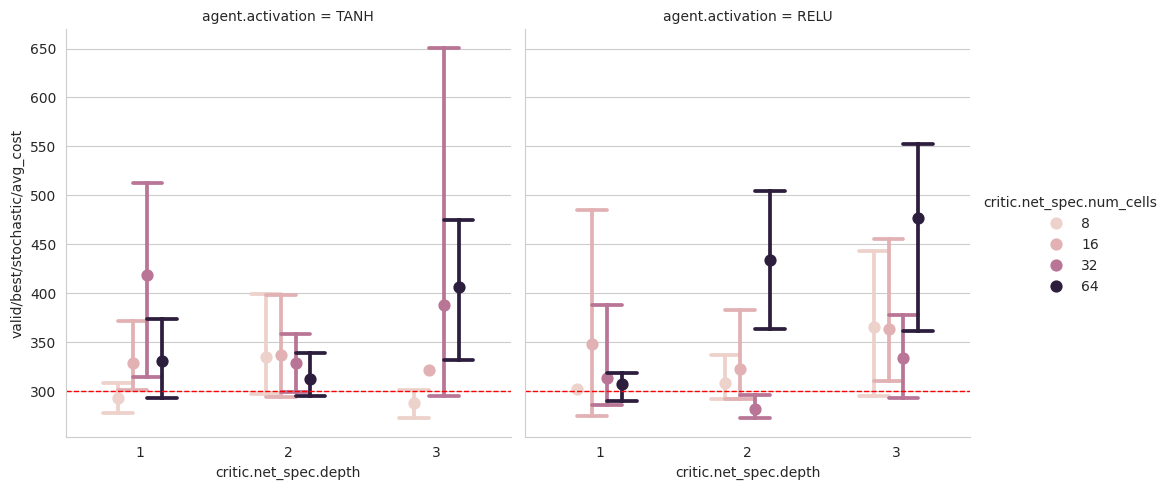

In [21]:
cplot = sns.catplot(filtered_df, x='critic.net_spec.depth', y=f'valid/best/stochastic/avg_cost', kind='point', 
            hue='critic.net_spec.num_cells', col='agent.activation',
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.3)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

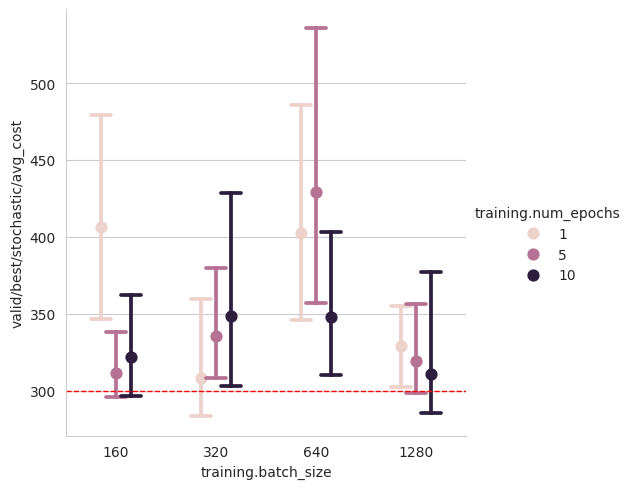

In [22]:
cplot = sns.catplot(filtered_df, x='training.batch_size', y=f'valid/best/stochastic/avg_cost', kind='point', 
            hue='training.num_epochs',
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.3)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

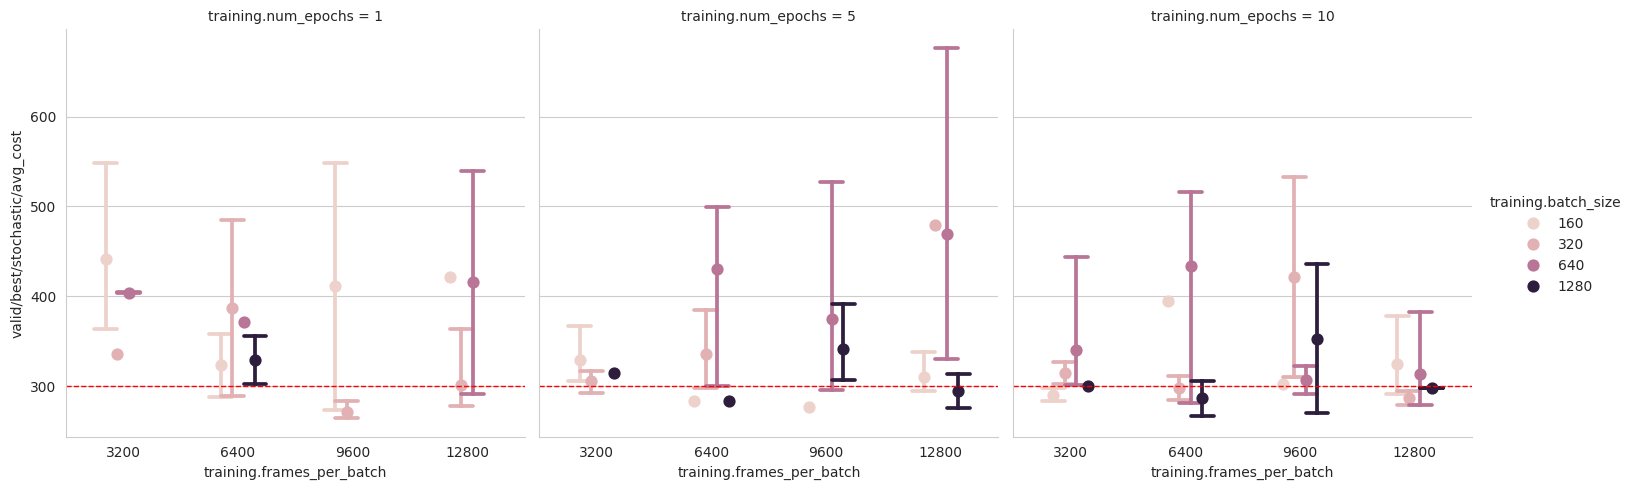

In [23]:
cplot = sns.catplot(filtered_df, x='training.frames_per_batch', y=f'valid/best/stochastic/avg_cost', kind='point', 
            hue='training.batch_size', col='training.num_epochs',
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.3)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

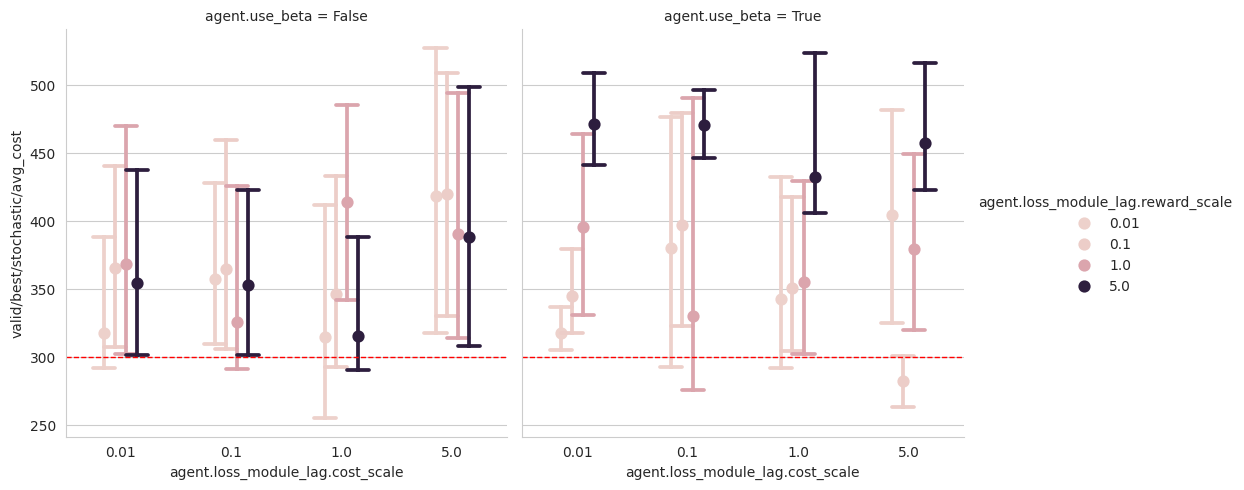

In [29]:
df = pd.read_csv('2jkoyjce/data.csv')
cplot = sns.catplot(df, x='agent.loss_module_lag.cost_scale', y=f'valid/best/stochastic/avg_cost', kind='point', 
            hue='agent.loss_module_lag.reward_scale', col='agent.use_beta',
                errorbar=lambda x: compute_ci(x), linestyles='', capsize=.2, dodge=0.3)
for ax in cplot.axes.flat:
    ax.axhline(300, linewidth=1, linestyle='--', color='r')

In [142]:
import wandb
api = wandb.Api()

def flows_plot(api, run_id, savename=None):
    FLOWS = ['input_storage', 'output_storage', 'storage_capacity', 'diesel_power', 'energy_bought', 'energy_sold']
    TITLES = ['input to storage system', 'output from storage system', 'storage capacity', 'diesel-generated power', 'energy bought from grid', 'energy sold to the grid']
    YLIM = [(0, 202), (0, 202), (0, 1012), (0, 1300), (0, 1750), (0, 607)]

    if not os.path.isfile(f'flows/{run_id}.csv'):
        run = api.run(f'unify/long-term-constraints/{run_id}')
        keys = [f'test/best/stochastic/{a}' for a in FLOWS]
        hist = run.scan_history(keys)
        df = pd.DataFrame([[h[f'test/best/stochastic/{a}'] for a in FLOWS] for h in hist], columns=FLOWS)
        df.to_csv(f'flows/{run_id}.csv', index=False)
    else:
        df = pd.read_csv(f'flows/{run_id}.csv')
    axes = df.plot(subplots=True, layout=(6, 1), figsize=(10, 12), legend=False, title=TITLES, xlabel='timestep', ylabel='units', xlim=(0, 95), xticks=np.arange(8, 97, 8), linewidth=1.5, colormap='Dark2')
    for i, ax in enumerate(axes.flatten()):
        ax.set_ylim(YLIM[i])
    plt.savefig(f'flows/{savename if savename is not None else run_id}.png', dpi=300)

def cvirt_plot(api, run_id, savename=None):
    if not os.path.isfile(f'flows/{run_id}-cvirts.csv'):
        run = api.run(f'unify/long-term-constraints/{run_id}')
        keys = [f'test/best/stochastic/{a}' for a in ['c_virt_in', 'c_virt_out']]
        hist = run.scan_history(keys)
        df = pd.DataFrame([[h[f'test/best/stochastic/{a}'] for a in ['c_virt_in', 'c_virt_out']] for h in hist], columns=['c_virt_in', 'c_virt_out'])
        df.to_csv(f'flows/{run_id}-cvirts.csv', index=False)
    else:
        df = pd.read_csv(f'flows/{run_id}-cvirts.csv')
    title = ["$c_{virt}^{in}$", "$c_{virt}^{out}$"]
    sharex = (len(df['c_virt_in'].unique()) > 1 and len(df['c_virt_out'].unique()) > 1)
    axes = df.plot(subplots=True, layout=(len(df.columns), 1), figsize=(8, 8), sharex=sharex, legend=False, title=title, ylabel='value', xlabel='timestep', xlim=(0, 95), xticks=np.arange(8, 97, 8), linewidth=1.5, colormap='Dark2')
    if len(df['c_virt_in'].unique()) == 1:
        axes[0, 0].remove()
    elif len(df['c_virt_out'].unique()) == 1:
        axes[1, 0].remove()
        axes[0, 0].set_xlabel('timestep')
    plt.savefig(f'flows/{savename if savename is not None else run_id}-cvirts.png', dpi=300)

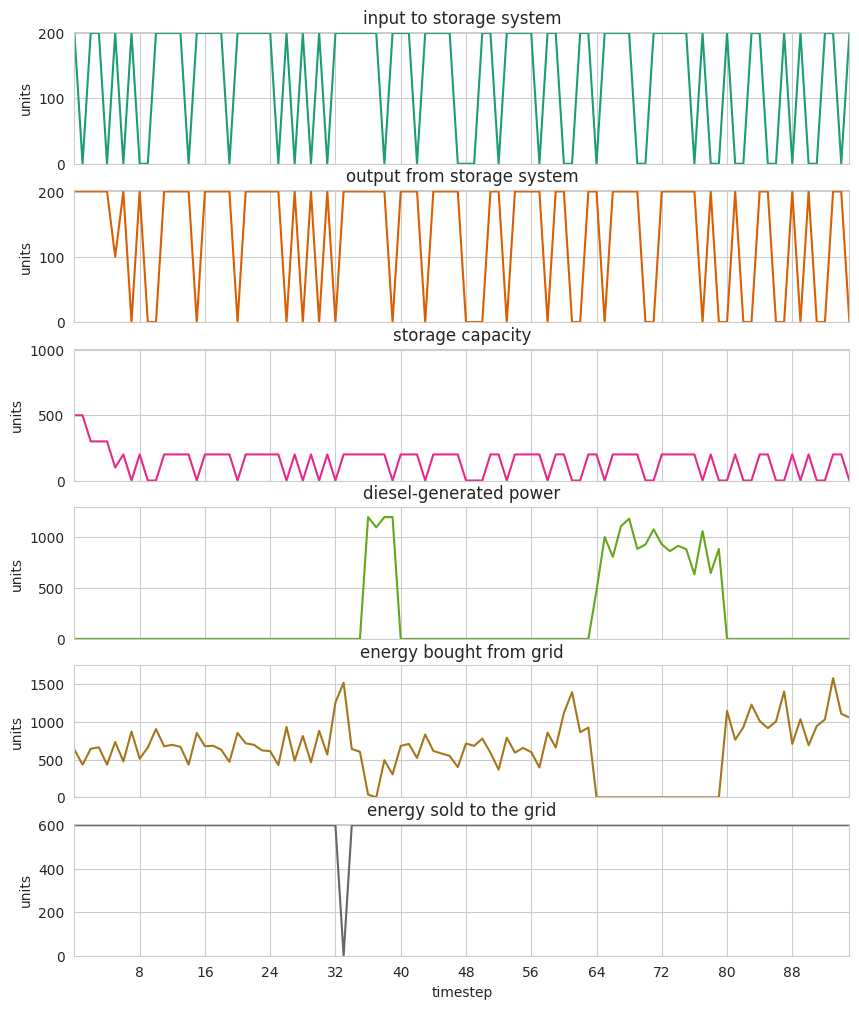

In [82]:
flows_plot(api, 'eenxw92l', 'flow_cvirtin')

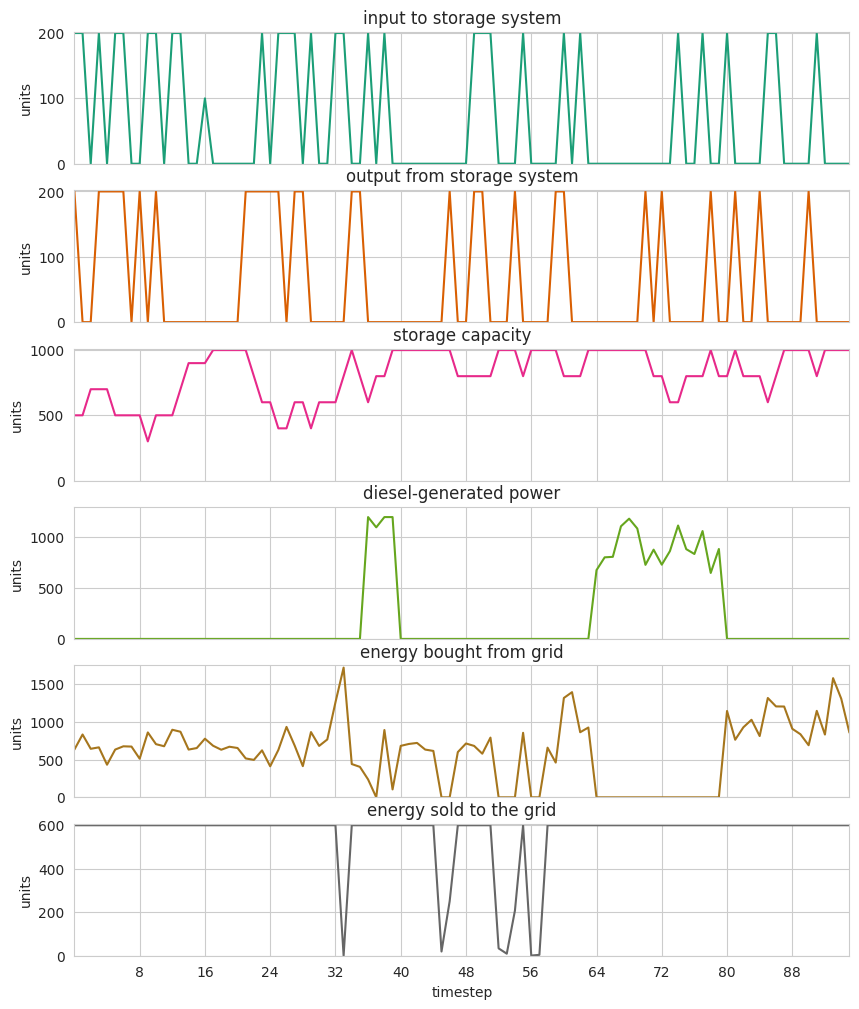

In [84]:
flows_plot(api, 'j2w70tf2', 'flow_bothcvirts')

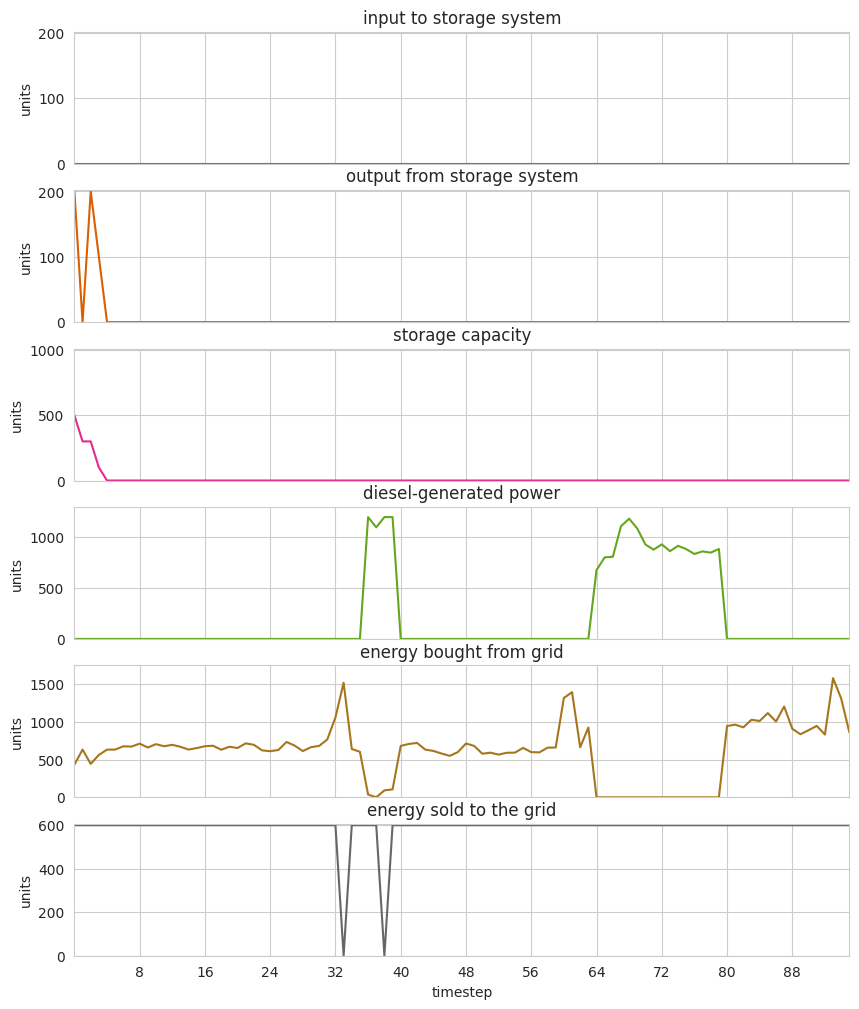

In [87]:
flows_plot(api, '0vkux1y9', 'flow_cvirtout')

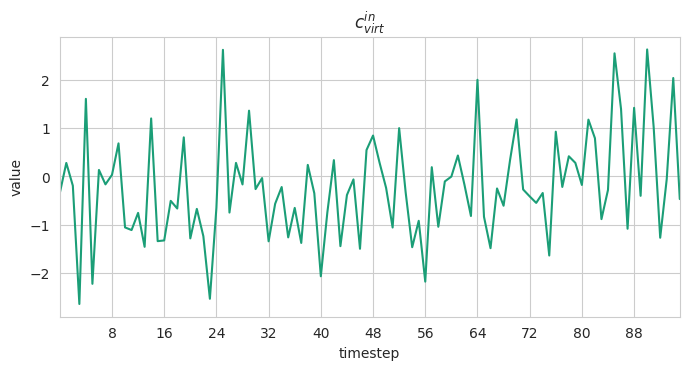

In [143]:
cvirt_plot(api, 'eenxw92l', 'cvirt_in')

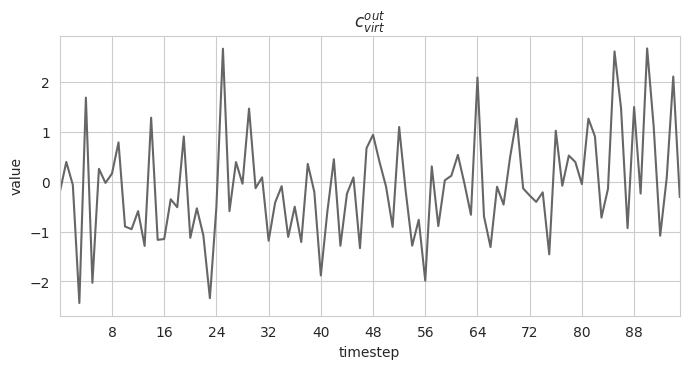

In [144]:
cvirt_plot(api, '0vkux1y9', 'cvirt_out')

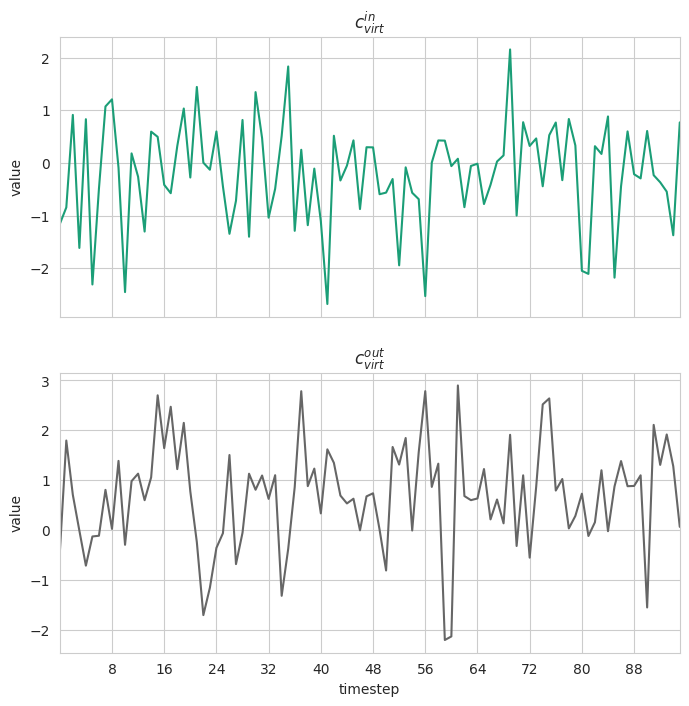

In [145]:
cvirt_plot(api, 'j2w70tf2', 'both_cvirts')